In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import seaborn as sns
from shapely import geometry
from shapely import wkt

In [2]:
# euclidean distance
TL, TR, BL, BR = np.array((103.6, 1.475)), np.array((104.05, 1.475)), np.array((103.6, 1.208)), np.array((104.05, 1.208))
length_km = np.linalg.norm(TR - TL)*100
print('length', length_km)
width_km = np.linalg.norm(TL - BL)*100
print('width', width_km)

length 45.000000000000284
width 26.700000000000014


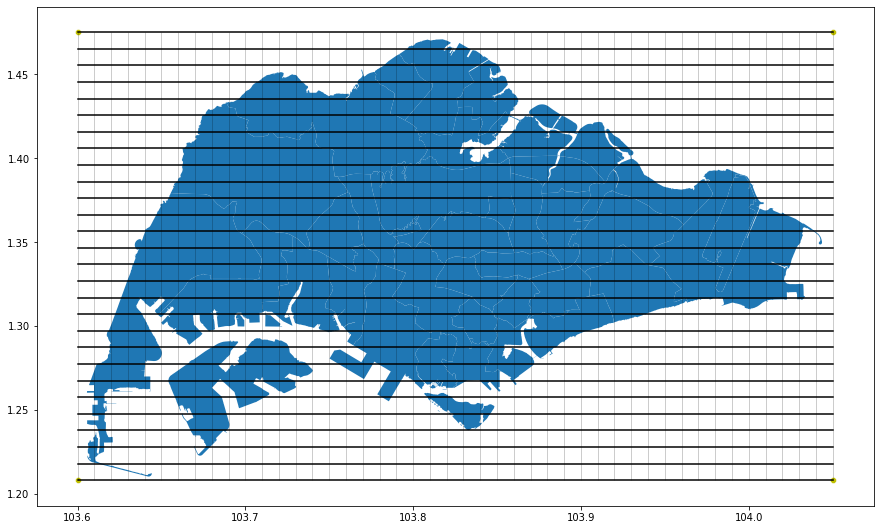

In [3]:
## Function to plot grids
def grid(size): # in metres
    # Read SG map
    gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
    whole_sg = gpd.read_file('singapore-police-force-npc-boundary/spf-boundaries.kml', driver='KML')
    
    # Divide length and widths
    vertical = round(45000/size)
    horizontal = round(26700/size)
    
    length_blocks = np.linspace(103.6, 104.05, num=vertical+1) #x
    width_blocks = np.linspace(1.208, 1.475, num=horizontal+1) #y
    
    # Plotting
    y = [1.475, 1.475, 1.208, 1.208]
    x = [103.6, 104.05, 103.6, 104.05]
    
    whole_sg.plot(figsize=(15,15))
    corner = sns.scatterplot(x=x,y=y, color = 'y')
    
    for i in length_blocks:
        sns.lineplot(x=[i,i], y=[1.208,1.475], color = 'black')

    for i in width_blocks:
        sns.lineplot(x=[103.6, 104.05], y=[i,i], color = 'black')
        
grid(1000)

In [4]:
## Function to know start end of grids
def blocks_coord(size): # in metres
    # Divide length and widths
    vertical = round(45000/size)
    horizontal = round(26700/size)
    
    length_blocks = np.linspace(103.6, 104.05, num=vertical+1) #x
    width_blocks = np.linspace(1.475, 1.208, num=horizontal+1) #y
    
    return length_blocks, width_blocks

length_blocks, rev_width_blocks = blocks_coord(1000)

In [5]:
## Create Dataframe
grid_df = pd.DataFrame(
    {'grid_num': [],
    'Coordinates':[]})
grid_df

count = 1
for i in range(len(rev_width_blocks)-1): # fix y first, 
    for j in range(len(length_blocks)-1): # then keep looping x (going to the right)
        # Top L, Top R, Btm R, Btm L
        p1 = geometry.Point(length_blocks[j],rev_width_blocks[i])
        p2 = geometry.Point(length_blocks[j+1],rev_width_blocks[i])
        p3 = geometry.Point(length_blocks[j+1],rev_width_blocks[i+1])
        p4 = geometry.Point(length_blocks[j],rev_width_blocks[i+1])
        
        pointList = [p1,p2,p3,p4]
        #print(length_blocks[i],rev_width_blocks[i])
        poly = geometry.Polygon([[p.x, p.y] for p in pointList])
        
        grid_df = grid_df.append(pd.DataFrame(
                            {'grid_num': count,
                            'Coordinates':[str(poly)]}), ignore_index=True)
        count +=1

In [6]:
## Convert to geopandas dataframe
grid_df['geometry'] = grid_df.Coordinates.apply(wkt.loads)
gdf = gpd.GeoDataFrame(grid_df, geometry='geometry')
gdf.drop('Coordinates', inplace=True, axis=1)
gdf

,grid_num,geometry
0,1.0,"POLYGON ((103.60000 1.47500, 103.61000 1.47500..."
1,2.0,"POLYGON ((103.61000 1.47500, 103.62000 1.47500..."
2,3.0,"POLYGON ((103.62000 1.47500, 103.63000 1.47500..."
3,4.0,"POLYGON ((103.63000 1.47500, 103.64000 1.47500..."
4,5.0,"POLYGON ((103.64000 1.47500, 103.65000 1.47500..."
...,...,...
1210,1211.0,"POLYGON ((104.00000 1.21789, 104.01000 1.21789..."
1211,1212.0,"POLYGON ((104.01000 1.21789, 104.02000 1.21789..."
1212,1213.0,"POLYGON ((104.02000 1.21789, 104.03000 1.21789..."
1213,1214.0,"POLYGON ((104.03000 1.21789, 104.04000 1.21789..."


In [7]:
#Export to shapefile
gdf.to_file('SG_grid/SG_grids.shp')

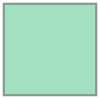

In [8]:
gdf['geometry'][0]